In [4]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Cleaning

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
import re

REPLACE_BY_SPLACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [10]:
def clean_text(text):
  text = text.lower()
  text = REPLACE_BY_SPLACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub('', text)
  text = text.replace('x', '')
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text

In [11]:
df['review'] = df['review'].apply(clean_text)

df['review'] = df['review'].str.replace('\d+','')

### Make the label to be 1 and 0 for binary classification

In [12]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [13]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [14]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production br br filming tech...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


### Modeling

1. Vectorie input
2. Limit dataset to top 50000 words
3. Set max number of words in each review to 250

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words = MAX_NB_WORDS,
                      filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)
tokenizer.fit_on_texts(df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.'%len(word_index))

Found 165306 unique tokens.


In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['review'].values)[:2500]
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2500, 250)


In [18]:
df['review'].values[0]

'one reviewers mentioned watching 1 oz episode youll hooked right eactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs se violence hardcore classic use wordbr br called oz nickname given oswald maimum security state penitentary focuses mainly emerald city eperimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered mi

In [19]:
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     4,  1834,   950,    57,   233,
        3193,   288,   353,  3079,   110,   492,   480,  2107,     1,
          20,    58,  3138,  3193,  5451, 15271,    51,   461,   182,
         110,   560,    53,  1585,    42,  8154,  5657, 11761,    42,
        2394,  5953,  5452,  1337,   264,   461,  3267,   249,   239,
       23365,     1,

## Convert output label into numeric format

In [21]:
Y = pd.get_dummies(df['sentiment']).values[:2500]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2500, 2)


In [22]:
Y

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [ True, False],
       [False,  True]])

## Split dataset to Training and Test set

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1750, 250) (1750, 2)
(750, 250) (750, 2)


## Construct LSTM Text Classifier

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs=3
batch_size=64

history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 748ms/step - accuracy: 0.5168 - loss: 0.6918 - val_accuracy: 0.5429 - val_loss: 0.6711
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 677ms/step - accuracy: 0.8019 - loss: 0.5706 - val_accuracy: 0.7314 - val_loss: 0.5145
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 668ms/step - accuracy: 0.9460 - loss: 0.2049 - val_accuracy: 0.8114 - val_loss: 0.4903


## Evaluate the model

In [28]:
acc = model.evaluate(X_test, Y_test)
print('Test set \n\tLoss: {:0.3f}\n\tAccuracy: {:0.3f}'.format(acc[0], acc[1]))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8113 - loss: 0.4390
Test set 
	Loss: 0.435
	Accuracy: 0.813


## Loss

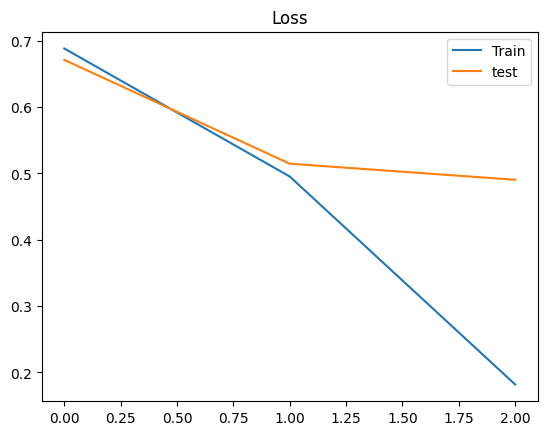

In [30]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Accuracy

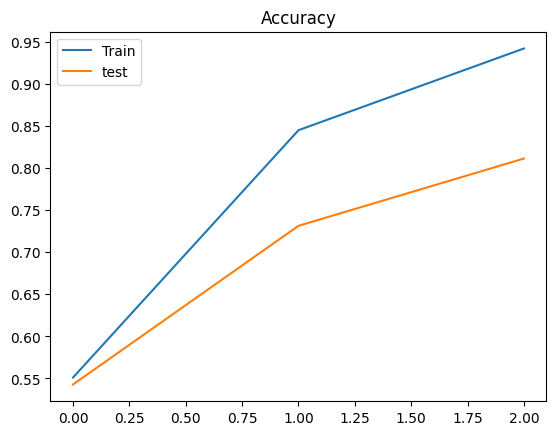

In [31]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Confusion Matrix

In [32]:
labels = pd.get_dummies(df['sentiment']).columns
list(labels)

[0, 1]

In [33]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)

# confusion_matrix(Y_test.argmax(axis=1),
#                  y_pred.argmax(axis=1))

pd.DataFrame(confusion_matrix(Y_test.argmax(axis=1),
                              y_pred.argmax(axis=1)),
             index=labels, columns=labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step


,0,1
0,298,79
1,61,312


## Classification Report

In [34]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_true=Y_test.argmax(axis=1),
                            y_pred=y_pred.argmax(axis=1)))

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       377
           1       0.80      0.84      0.82       373

    accuracy                           0.81       750
   macro avg       0.81      0.81      0.81       750
weighted avg       0.81      0.81      0.81       750



## Test using new review from Deadpool Wolverine.


In [42]:
new_review = ['''I’ve waited for more than 2 years for this cinematic masterpiece to ultimately debut in theaters as the ultimate live-action Deadpool movie outing and it conveniently blew my expectations away by more than a mere potshot.
To elucidate this belief in my case, I myself watched this film the first at Reading Cinemas Town Square on Tuesday July 30th, 2024 at 6:15PM, everything about this film was terrific, whether that be, (SPOILER-FREE CRITIQUE), a couple of cameos, comebacks, (the biggest being Wolverine and how well executed and stalwart the cast and crew remained for Hugh Jackman’s portrayal of the character, nice). The new characters were pretty phenomenal for everything that had been culminated into a presentation of greatness and cabaret no less. And also sorry for the 20th Century FOX universe about to be altered for eternity, (Diss to the knee, even with Blue Sky Studios), you shall be paid proper homage for your years of nostalgia, (if someone didn’t probably do so for you already). The cinematography was well mentally and crucially balanced for the tone of seriousness with gory violence and facetious humor that blew me away even for the 3rd time in a long time, (in forever), stellar portrayals for prom the thespians, (especially for the renowned Ryan Reynolds and Hugh Jackman as the prime eponymous protagonists).
As for the prime antagonist, I wasn’t too agitated and irritably bothered by one of the antagonists being Cassandra Nova, (but that’s less incorrigibly made up for by Paradox, who I thought to be another different variant of Mobius, but I’m more than erroneous up to that particular point). The heavy emotions were carried out nicely as well as the choreography fight scenarios were in the least with a bundle of different ensemble characters from the past, (shan’t mention who specifically but good things come to those who wait, even if it isn’t everything everywhere all at once, ;) alluding to another 2022 multiverse movie). And did I forget to conscientiously mention about the costume designs for not merely Deadpool but also Wolverine, nice homage to the glorious late 30s comic-book accurate appeal, it’s rather satisfying and riveting for how well it was approached in that regard without being to mundane or that overall garnished somewhat. The music homages and the soundtrack was phenomenal as I almost forgot to mention for the prior precursors of Deadpool, (I’ll avow to not disclose), and hopefully maybe Deadpool won’t merely become Marvel Jesus and alter the course of the status quo of the MCU Phases 4 and beyond, can’t wait for much more in store becoming cooking up a  concocted pall.
Overall, this true pure magnum opus is all the more breathtaking to say for the least that is truly, and might just practically even surpass its precursors by a mere milestone, this for me gets a 9.9/10, no more, no less. ''']


In [43]:
import numpy as np

seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels=pd.get_dummies(df['sentiment']).columns.values
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
[[0.14448868 0.85551125]] 1
